In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:

# Load your data
data = pd.read_csv('/content/train.csv')  # Replace 'your_data.csv' with your dataset
dt = pd.read_csv('/content/test.csv')

In [ ]:
dt.shape

(100, 4)

In [ ]:
data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,1/6/2015,66.208486,75.609978,298506300,Hold
1,1,8/6/2015,64.116235,74.443331,227974800,Hold
2,2,15/6/2015,47.701942,71.140831,250670900,Buy
3,3,22/6/2015,54.754816,72.881344,223614300,Hold
4,4,29/6/2015,48.031900,66.284718,406814900,Buy


In [ ]:
ffg = pd.DataFrame()
ffg['Opn'] = data.Open
ffg

,Opn
0,66.208486
1,64.116235
2,47.701942
3,54.754816
4,48.031900
...,...
295,81.284821
296,71.970249
297,71.784627
298,69.372333


In [ ]:
# # # Feature engineering
# data['Close_Lag1'] = data['Close'].shift(1)  # Example of creating a lag feature

# # Drop rows with missing values due to creating lag features
# data.dropna(inplace=True)

In [ ]:
# Define features and target variables
# X = data[['Close', 'Open', 'Volume', 'Close_Lag1']]
# X = data[[ 'Open', 'Volume',]]
# y_reg = data['Close']  # Target variable for regression (Close prices)
# y_cls = data['Strategy']  # Target variable for classification (Buy, Sell, Hold)

In [ ]:
import pandas as pd

def feature_eng(data):
    result = pd.DataFrame()
    result['Open'] = data.Open

    num_lags = 5  # Choose the number of lag features
    for i in range(1, num_lags + 1):
        result[f'Open_Lag_{i}'] = data['Open'].shift(i)

    # Short-term Moving Average (e.g., 5 days)
    result['Open_Short_Moving_Avg'] = data['Open'].rolling(window=5).mean()

    # Long-term Moving Average (e.g., 20 days)
    result['Open_Long_Moving_Avg'] = data['Open'].rolling(window=20).mean()

    # Exponential Moving Averages (EMAs) with different alpha values
    for alpha in [0.1, 0.2, 0.5]:  # You can choose different smoothing factors (alpha)
        short_term_ema_col = f'Open_Short_Term_EMA_{alpha}'
        medium_term_ema_col = f'Open_Medium_Term_EMA_{alpha}'
        long_term_ema_col = f'Open_Long_Term_EMA_{alpha}'

        result[short_term_ema_col] = data['Open'].ewm(alpha=alpha, adjust=False).mean()
        result[medium_term_ema_col] = data['Open'].ewm(alpha=alpha, adjust=False).mean()
        result[long_term_ema_col] = data['Open'].ewm(alpha=alpha, adjust=False).mean()

    return result


In [ ]:
# # Short-term Moving Average (e.g., 5 days)
#       data['Open_Short_Moving_Avg'] = data['Open'].rolling(window=5).mean()

# # Long-term Moving Average (e.g., 20 days)
#       data['Open_Long_Moving_Avg'] = data['Open'].rolling(window=20).mean()

In [ ]:
# def calculate_rsi(data, window=14):
#     delta = data['Close'].diff()

#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

#     rs = gain / loss
#     data['RSI'] = 100 - (100 / (1 + rs))

# data['Open_rsi'] = calculate_rsi(data)

In [ ]:
#       data['Volume_Change'] = data['Volume'].diff()

# # Percentage change in volume
#       data['Volume_Percent_Change'] = data['Volume'].pct_change() * 100
#       result = data

In [ ]:
result_data = feature_eng(data)
result_data

,Open,Open_Lag_1,Open_Lag_2,Open_Lag_3,Open_Lag_4,Open_Lag_5,Open_Short_Moving_Avg,Open_Long_Moving_Avg,Open_Short_Term_EMA_0.1,Open_Medium_Term_EMA_0.1,Open_Long_Term_EMA_0.1,Open_Short_Term_EMA_0.2,Open_Medium_Term_EMA_0.2,Open_Long_Term_EMA_0.2,Open_Short_Term_EMA_0.5,Open_Medium_Term_EMA_0.5,Open_Long_Term_EMA_0.5
0,66.208486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486
1,64.116235,66.208486,NaN,NaN,NaN,NaN,NaN,NaN,65.999261,65.999261,65.999261,65.790036,65.790036,65.790036,65.162361,65.162361,65.162361
2,47.701942,64.116235,66.208486,NaN,NaN,NaN,NaN,NaN,64.169529,64.169529,64.169529,62.172417,62.172417,62.172417,56.432151,56.432151,56.432151
3,54.754816,47.701942,64.116235,66.208486,NaN,NaN,NaN,NaN,63.228058,63.228058,63.228058,60.688897,60.688897,60.688897,55.593484,55.593484,55.593484
4,48.031900,54.754816,47.701942,64.116235,66.208486,NaN,56.162676,NaN,61.708442,61.708442,61.708442,58.157497,58.157497,58.157497,51.812692,51.812692,51.812692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,81.284821,80.663736,79.840215,80.490487,81.278395,80.361799,80.711531,78.167510,78.870477,78.870477,78.870477,80.030761,80.030761,80.030761,80.850407,80.850407,80.850407
296,71.970249,81.284821,80.663736,79.840215,80.490487,81.278395,78.849902,78.145700,78.180454,78.180454,78.180454,78.418659,78.418659,78.418659,76.410328,76.410328,76.410328
297,71.784627,71.970249,81.284821,80.663736,79.840215,80.490487,77.108730,77.932409,77.540872,77.540872,77.540872,77.091852,77.091852,77.091852,74.097478,74.097478,74.097478
298,69.372333,71.784627,71.970249,81.284821,80.663736,79.840215,75.015154,77.871039,76.724018,76.724018,76.724018,75.547949,75.547949,75.547949,71.734906,71.734906,71.734906


In [ ]:
X = result_data[['Open', 'Open_Lag_1', 'Open_Lag_2', 'Open_Lag_3', 'Open_Lag_4', 'Open_Lag_5', 'Open_Short_Moving_Avg', 'Open_Long_Moving_Avg', 'Open_Short_Term_EMA_0.1', 'Open_Medium_Term_EMA_0.1', 'Open_Long_Term_EMA_0.1', 'Open_Short_Term_EMA_0.2', 'Open_Medium_Term_EMA_0.2', 'Open_Long_Term_EMA_0.2', 'Open_Short_Term_EMA_0.5', 'Open_Medium_Term_EMA_0.5', 'Open_Long_Term_EMA_0.5']]

X_cls = result_data[['Open', 'Open_Lag_1', 'Open_Lag_2', 'Open_Lag_3', 'Open_Lag_4', 'Open_Lag_5', 'Open_Short_Moving_Avg', 'Open_Long_Moving_Avg', 'Open_Short_Term_EMA_0.1', 'Open_Medium_Term_EMA_0.1', 'Open_Long_Term_EMA_0.1', 'Open_Short_Term_EMA_0.2', 'Open_Medium_Term_EMA_0.2', 'Open_Long_Term_EMA_0.2', 'Open_Short_Term_EMA_0.5', 'Open_Medium_Term_EMA_0.5', 'Open_Long_Term_EMA_0.5']]
X_cls['Close'] = data['Close']

y_reg = data['Close']
y_cls = data['Strategy']  # Target variable for classification (Buy, Sell, Hold)


In [ ]:
X.head()

,Open,Open_Lag_1,Open_Lag_2,Open_Lag_3,Open_Lag_4,Open_Lag_5,Open_Short_Moving_Avg,Open_Long_Moving_Avg,Open_Short_Term_EMA_0.1,Open_Medium_Term_EMA_0.1,Open_Long_Term_EMA_0.1,Open_Short_Term_EMA_0.2,Open_Medium_Term_EMA_0.2,Open_Long_Term_EMA_0.2,Open_Short_Term_EMA_0.5,Open_Medium_Term_EMA_0.5,Open_Long_Term_EMA_0.5
0,66.208486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486,66.208486
1,64.116235,66.208486,NaN,NaN,NaN,NaN,NaN,NaN,65.999261,65.999261,65.999261,65.790036,65.790036,65.790036,65.162361,65.162361,65.162361
2,47.701942,64.116235,66.208486,NaN,NaN,NaN,NaN,NaN,64.169529,64.169529,64.169529,62.172417,62.172417,62.172417,56.432151,56.432151,56.432151
3,54.754816,47.701942,64.116235,66.208486,NaN,NaN,NaN,NaN,63.228058,63.228058,63.228058,60.688897,60.688897,60.688897,55.593484,55.593484,55.593484
4,48.031900,54.754816,47.701942,64.116235,66.208486,NaN,56.162676,NaN,61.708442,61.708442,61.708442,58.157497,58.157497,58.157497,51.812692,51.812692,51.812692


In [ ]:
# Splitting the data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, shuffle=False)

# Splitting the data into training and testing sets for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, shuffle=False)

In [ ]:
from xgboost import XGBRegressor

# Create the XGBoost regression model with specified hyperparameters
reg_model = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100)

# Fit the model with training data
reg_model.fit(X_train_reg, y_train_reg)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictionss_df = pd.DataFrame(index=X_test_reg.index)
# predictionss_df['Close', 'predicted']
predictionss_df['Close'] = y_test_reg
predictionss_df['predicted'] = reg_model.predict(X_test_reg)
predictionss_df


,Close,predicted
240,71.365903,73.834534
241,74.212029,74.115425
242,75.110591,76.982407
243,79.059896,78.912079
244,86.154937,82.048805
245,82.494413,82.386948
246,84.264270,83.548492
247,81.916434,82.962639
248,81.487762,82.890823
249,78.500217,82.402428


In [ ]:
# reg_predictions = reg_model.predict(X_test_reg)
# reg_predictions
# predictions = ['Actual', 'Predicted']
# predictions['Actual'] =

In [ ]:
smape = np.mean(np.abs(predictionss_df['predicted'] - predictionss_df['Close']) / (np.abs(predictionss_df['predicted']) + np.abs(predictionss_df['Close'])))

In [ ]:
smape

0.011270186844095455

In [ ]:


# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the string labels to numerical labels
y_train_cls_encoded = label_encoder.fit_transform(y_train_cls)

In [ ]:
y_train_cls

0      Hold
1      Hold
2       Buy
3      Hold
4       Buy
       ... 
235    Hold
236     Buy
237     Buy
238     Buy
239     Buy
Name: Strategy, Length: 240, dtype: object

In [ ]:
y_train_cls_encoded

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])

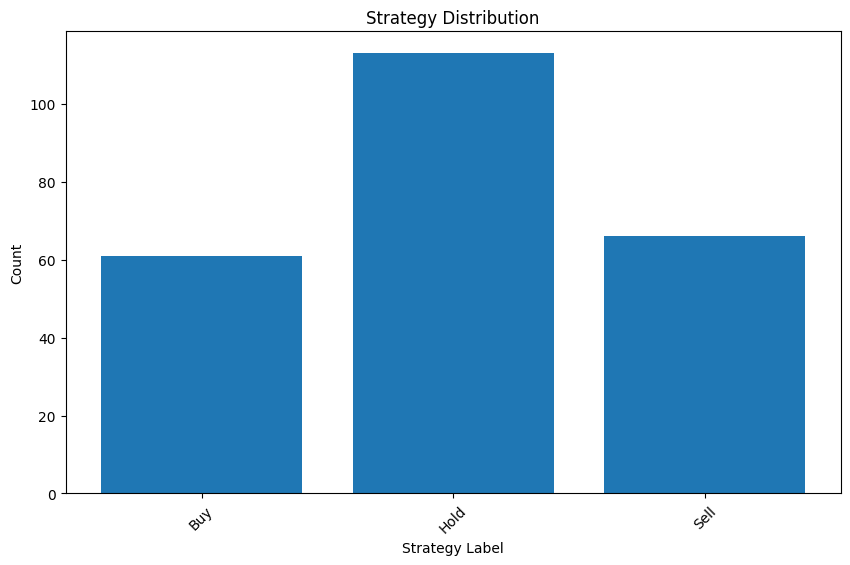

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
unique, counts = np.unique(y_train_cls, return_counts=True)
plt.bar(unique, counts)
plt.title("Strategy Distribution")
plt.xlabel("Strategy Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Calculate class weights to handle the imbalance
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train_cls), y=y_train_cls)
#class_weight_dict = dict(enumerate(class_weights))

# Create a Random Forest classifier with class weights and an imputer for missing values
cls_model = RandomForestClassifier()

# Define a parameter grid to search for the best hyperparameters for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # You can adjust the number of trees
    'classifier__max_depth': [3, 4, 5],  # You can adjust the maximum depth of the trees
}

# Create an imputer for missing values
imputer = SimpleImputer(strategy='mean')  # You can choose a different imputation strategy

# Create a pipeline that imputes missing values and fits a Random Forest Classifier
pipeline = Pipeline([
    ('imputer', imputer),
    ('classifier', cls_model)
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_cls, y_train_cls_encoded)

# Get the best parameters
best_params = grid_search.best_params_
best_cls_model = grid_search.best_estimator_

# Now, best_cls_model is the Random Forest Classifier with the best hyperparameters and class weights
best_cls_model.fit(X_train_cls, y_train_cls_encoded)  # Train the model with class weights and imputation


Fitting 5 folds for each of 9 candidates, totalling 45 fits


Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 RandomForestClassifier(max_depth=3, n_estimators=300))])

In [ ]:
X_test_cls.head()

,Open,Open_Lag_1,Open_Lag_2,Open_Lag_3,Open_Lag_4,Open_Lag_5,Open_Short_Moving_Avg,Open_Long_Moving_Avg,Open_Short_Term_EMA_0.1,Open_Medium_Term_EMA_0.1,Open_Long_Term_EMA_0.1,Open_Short_Term_EMA_0.2,Open_Medium_Term_EMA_0.2,Open_Long_Term_EMA_0.2,Open_Short_Term_EMA_0.5,Open_Medium_Term_EMA_0.5,Open_Long_Term_EMA_0.5,Close
240,74.811495,71.108020,67.967818,66.278431,71.841477,70.289227,70.401448,79.180577,76.280135,76.280135,76.280135,72.857034,72.857034,72.857034,72.302289,72.302289,72.302289,71.365903
241,80.812144,74.811495,71.108020,67.967818,66.278431,71.841477,72.195581,78.716735,76.733336,76.733336,76.733336,74.448056,74.448056,74.448056,76.557216,76.557216,76.557216,74.212029
242,82.002162,80.812144,74.811495,71.108020,67.967818,66.278431,75.340328,78.095141,77.260218,77.260218,77.260218,75.958877,75.958877,75.958877,79.279689,79.279689,79.279689,75.110591
243,81.211918,82.002162,80.812144,74.811495,71.108020,67.967818,77.989148,77.730771,77.655388,77.655388,77.655388,77.009485,77.009485,77.009485,80.245803,80.245803,80.245803,79.059896
244,79.468382,81.211918,82.002162,80.812144,74.811495,71.108020,79.661220,77.359884,77.836687,77.836687,77.836687,77.501265,77.501265,77.501265,79.857093,79.857093,79.857093,86.154937


In [ ]:
cls_predictions = best_cls_model.predict(X_test_cls)
res = []
for i in cls_predictions:
    res.append(i)

for i in range(len(res)):
    if res[i] == 1:
        res[i] = 'Hold'

    elif res[i] == 0:
        res[i] = 'Buy'

    elif res[i] == 2:
        res[i] = 'Sell'
cls_predictions = res
cls_predictions

['Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold',
 'Hold']

In [ ]:
# Evaluate the classification model
accuracy = accuracy_score(y_test_cls, cls_predictions)
print(f'Classification Accuracy: {accuracy}')


Classification Accuracy: 0.5


In [ ]:
dt.head()

,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400


In [ ]:
result_dt = feature_eng(dt)
result_dt

,Open,Open_Lag_1,Open_Lag_2,Open_Lag_3,Open_Lag_4,Open_Lag_5,Open_Short_Moving_Avg,Open_Long_Moving_Avg,Open_Short_Term_EMA_0.1,Open_Medium_Term_EMA_0.1,Open_Long_Term_EMA_0.1,Open_Short_Term_EMA_0.2,Open_Medium_Term_EMA_0.2,Open_Long_Term_EMA_0.2,Open_Short_Term_EMA_0.5,Open_Medium_Term_EMA_0.5,Open_Long_Term_EMA_0.5
0,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331
1,73.310886,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,72.768587,72.768587,72.768587,72.828842,72.828842,72.828842,73.009609,73.009609,73.009609
2,70.610119,73.310886,72.708331,NaN,NaN,NaN,NaN,NaN,72.552740,72.552740,72.552740,72.385097,72.385097,72.385097,71.809864,71.809864,71.809864
3,70.256017,70.610119,73.310886,72.708331,NaN,NaN,NaN,NaN,72.323068,72.323068,72.323068,71.959281,71.959281,71.959281,71.032940,71.032940,71.032940
4,68.258324,70.256017,70.610119,73.310886,72.708331,NaN,71.028735,NaN,71.916593,71.916593,71.916593,71.219090,71.219090,71.219090,69.645632,69.645632,69.645632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,57.048622,55.184092,58.417757,59.428165,57.967017,60.016358,57.609131,57.873293,58.740949,58.740949,58.740949,57.191260,57.191260,57.191260,56.910196,56.910196,56.910196
96,60.569661,57.048622,55.184092,58.417757,59.428165,57.967017,58.129659,57.985505,58.923820,58.923820,58.923820,57.866940,57.866940,57.866940,58.739928,58.739928,58.739928
97,61.446777,60.569661,57.048622,55.184092,58.417757,59.428165,58.533382,58.322605,59.176116,59.176116,59.176116,58.582908,58.582908,58.582908,60.093353,60.093353,60.093353
98,55.447711,61.446777,60.569661,57.048622,55.184092,58.417757,57.939373,58.457118,58.803275,58.803275,58.803275,57.955868,57.955868,57.955868,57.770532,57.770532,57.770532


Training Predictions

In [ ]:
result_dt.head()

,Open,Open_Lag_1,Open_Lag_2,Open_Lag_3,Open_Lag_4,Open_Lag_5,Open_Short_Moving_Avg,Open_Long_Moving_Avg,Open_Short_Term_EMA_0.1,Open_Medium_Term_EMA_0.1,Open_Long_Term_EMA_0.1,Open_Short_Term_EMA_0.2,Open_Medium_Term_EMA_0.2,Open_Long_Term_EMA_0.2,Open_Short_Term_EMA_0.5,Open_Medium_Term_EMA_0.5,Open_Long_Term_EMA_0.5
0,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331,72.708331
1,73.310886,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,72.768587,72.768587,72.768587,72.828842,72.828842,72.828842,73.009609,73.009609,73.009609
2,70.610119,73.310886,72.708331,NaN,NaN,NaN,NaN,NaN,72.552740,72.552740,72.552740,72.385097,72.385097,72.385097,71.809864,71.809864,71.809864
3,70.256017,70.610119,73.310886,72.708331,NaN,NaN,NaN,NaN,72.323068,72.323068,72.323068,71.959281,71.959281,71.959281,71.032940,71.032940,71.032940
4,68.258324,70.256017,70.610119,73.310886,72.708331,NaN,71.028735,NaN,71.916593,71.916593,71.916593,71.219090,71.219090,71.219090,69.645632,69.645632,69.645632


In [ ]:
# X_dt = dt[['Open', 'Volume']]
reg_predictions_2 = reg_model.predict(result_dt)
reg_predictions_2

array([76.90455 , 76.00187 , 73.48294 , 74.266365, 73.95649 , 73.72741 ,
       73.84626 , 73.725365, 73.725365, 73.23008 , 74.222694, 73.725365,
       73.84626 , 73.84626 , 74.33781 , 73.725365, 73.72741 , 73.72741 ,
       73.72741 , 74.206726, 73.45047 , 74.28511 , 75.399284, 76.71096 ,
       78.5508  , 79.48032 , 81.74814 , 82.89082 , 82.89082 , 82.89082 ,
       83.04124 , 82.55268 , 82.40581 , 82.89082 , 83.52963 , 85.32492 ,
       85.185905, 86.07239 , 88.92992 , 84.9624  , 89.4721  , 89.19978 ,
       83.920364, 75.763084, 74.612755, 73.996574, 74.115425, 74.115425,
       73.99453 , 74.60697 , 74.384476, 75.72693 , 74.87602 , 75.721146,
       76.98819 , 77.95665 , 79.48032 , 81.74814 , 82.89082 , 82.40243 ,
       82.55268 , 82.38695 , 85.76952 , 84.633896, 83.0102  , 77.41651 ,
       75.121284, 73.996574, 73.996574, 73.499245, 71.43705 , 71.97361 ,
       69.279434, 68.98072 , 69.077324, 69.077324, 68.75794 , 68.403   ,
       68.3788  , 66.514786, 64.23883 , 63.552032, 

In [ ]:
result_dt['Close'] = reg_predictions_2
cls_predictions_2 = best_cls_model.predict(result_dt)
res_2 = []
for i in cls_predictions_2:
    res_2.append(i)

for i in range(len(res_2)):
    if res_2[i] == 1:
        res_2[i] = 'Hold'

    elif res_2[i] == 0:
        res_2[i] = 'Buy'

    elif res_2[i] == 2:
        res_2[i] = 'Sell'
cls_predictions_2 = res_2

In [ ]:
# Assuming 'X_test_reg' contains the testing data for regression and 'X_test_cls' contains the testing data for classification.

# Create a DataFrame for the submission file
submission = pd.DataFrame()
submission['id'] = dt['id']
submission['Date'] = dt['Date']  # Assuming the index contains the dates in the test set
submission['Close'] = reg_predictions_2  # Predicted close prices
submission['Strategy'] = cls_predictions_2  # Predicted strategies
submission
# Convert numerical strategy predictions back to their original labels (Buy, Sell, Hold)
# Replace the encoding based on how it was originally encoded
# Example (modify according to your encoding):


,id,Date,Close,Strategy
0,0,2021-03-01,76.904549,Hold
1,1,2021-03-08,76.001869,Hold
2,2,2021-03-15,73.482941,Hold
3,3,2021-03-22,74.266365,Hold
4,4,2021-03-29,73.956490,Hold
...,...,...,...,...
95,95,2022-12-26,64.508522,Hold
96,96,2023-01-02,64.089035,Hold
97,97,2023-01-09,63.435783,Hold
98,98,2023-01-16,64.089035,Hold


In [ ]:
# Save the DataFrame to a CSV file
output_filename = "submission5.csv"

# Save the selected data to a new CSV file
submission.to_csv(output_filename, index=False)

final_csv = pd.read_csv('submission5.csv')
display(final_csv)

,id,Date,Close,Strategy
0,0,2021-03-01,76.904550,Hold
1,1,2021-03-08,76.001870,Hold
2,2,2021-03-15,73.482940,Hold
3,3,2021-03-22,74.266365,Hold
4,4,2021-03-29,73.956490,Hold
...,...,...,...,...
95,95,2022-12-26,64.508520,Hold
96,96,2023-01-02,64.089035,Hold
97,97,2023-01-09,63.435783,Hold
98,98,2023-01-16,64.089035,Hold
